In [26]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from multitest import MultiTest

import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
import pandas as pd

from test_gene_expression import reduce_time_resolution, two_groups_gene

from survival import *


## Load raw data:

In [27]:
df = pd.read_csv("./Data/SCANB_groups_valid.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

div_probs = df.agg(['mean'])
thresh = 0.001
valid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) < thresh]
invalid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) > thresh]
df.drop(columns = invalid_genes + ['Unnamed: 0'])

assert(len(invalid_genes) == 0)

print("Removed: ", 9259 - len(valid_genes))

Removed:  557


### Ilustrate data raw data

In [28]:
print(reduce_time_resolution(two_groups_gene(df, gene_name), T=100).astype(int).reset_index()\
      .drop(columns=['t','censored1','censored2'])\
      .filter(['at-risk1', 'dead1', 'at-risk2', 'dead2']).head(5)\
        .to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  at-risk1 &  dead1 &  at-risk2 &  dead2 \\
\midrule
0 &      1534 &      0 &      1535 &      1 \\
1 &      1534 &      0 &      1534 &      2 \\
2 &      1534 &      0 &      1532 &      0 \\
3 &      1534 &      2 &      1532 &      1 \\
4 &      1532 &      2 &      1531 &      1 \\
\bottomrule
\end{tabular}



/var/folders/3n/c1thdb3136qc3c_4t5br9r6c0000gq/T/ipykernel_28174/3386803395.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(reduce_time_resolution(two_groups_gene(df, gene_name), T=100).astype(int).reset_index()\


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  4.22it/s]


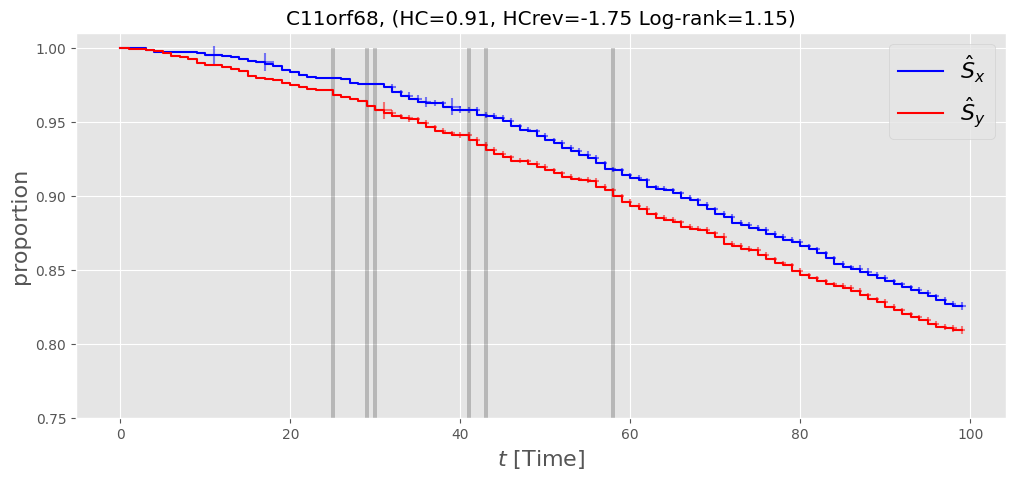

In [32]:
#from illustrate_gene_expression_results import illustrate_survival_curve_gene

from multitest import MultiTest

def find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True, gamma=.5):
    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    mt = MultiTest(pvals[pvals <= 1], stbl=stbl)
    hc, hct = mt.hc(gamma=gamma)
    return pvals <= hct


def illustrate_survival_curve_gene(df, gene_name, T, stbl=False,
                               show_HCT=True, randomize_HC=False):
    dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)

    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values

    stats = evaluate_test_stats(Nt1, Nt2, Ot1, Ot2, stbl=stbl, randomize=randomize_HC)
    stats_rev = evaluate_test_stats(Nt2, Nt1, Ot2, Ot1, stbl=stbl, randomize=randomize_HC)
    if stats['hc_greater'] < stats_rev['hc_greater']:  # reverse groups
        dfg = dfg.rename(columns={'at-risk1': 'at-risk2', 'at-risk2': 'at-risk1',
                                  'dead1': 'dead2', 'dead2': 'dead1',
                                  'censored1': 'censored2', 'censored2': 'censored1'
                                  })
        temp = stats
        stats = stats_rev
        stats_rev = temp

    Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
    Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values

    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=False)
    pvals_rev = multi_pvals(Nt2, Nt1, Ot2, Ot1, randomize=False)
    fpval = find_changes(Nt1, Nt2, Ot1, Ot2, stbl=True)

    dfg['pvalue'] = pvals
    dfg['pvalue_rev'] = pvals_rev
    cumc1 = dfg['censored1'].cumsum()
    cumc2 = dfg['censored2'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at-risk1'] - dfg['censored1']) / (dfg['at-risk1'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at-risk2'] - dfg['censored2']) / (dfg['at-risk2'].max() - cumc2)
    # dfg['censored1'] = dfg['at-risk1'] - dfg['']

    df_disp = dfg[fpval].rename(columns={'at-risk1': 'at-risk X', 'at-risk2': 'at-risk Y',
                                         'dead1': 'events X', 'dead2': 'events Y'
                                         })

    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored1'] > 0
    ct2 = dfg['censored2'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored1'].max() / dfg.loc[ct1, 'censored1']).values
    s2 = 10 * (dfg.loc[ct2, 'censored2'].max() / dfg.loc[ct2, 'censored2']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1, 'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2, 'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)

    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)

    if show_HCT:
        plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)

    plt.title(f"{gene_name}, (HC={np.round(stats['hc_greater'],2)}, HCrev={np.round(stats_rev['hc_greater'],2)} Log-rank={np.round(stats['log_rank_greater'],2)})")
    plt.ylabel('proportion', fontsize=16)
    plt.xlabel(r'$t$ [Time]', fontsize=16)
    plt.ylim([0.7, 1.01])

    return df_disp, dfg



plt.rcParams['figure.figsize'] =  [12, 5]
T = 100


for gene_name in tqdm([#'ATP6V1B1',
                        'C11orf68']):
    dfp, dfg = illustrate_survival_curve_gene(df, gene_name, T, stbl=False, show_HCT=True)
plt.ylim([.75 ,1.01])
#plt.savefig(f"{gene_name}.png")
plt.show()

## Report null values

In [392]:
def infmean(x):
    "mean ignoring inf values"
    return np.mean(np.ma.masked_invalid(x))

def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)


def q99(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .99)


def infstd(x):
    return np.std(np.ma.masked_invalid(x))


In [395]:
T = 200
M = 1
stbl = True
#df0 = pd.read_csv("results/SCANB_null_False_T50_False_rep1.csv")
#df0 = pd.read_csv("results/SCANB_null_True_T100.csv")
df0 = pd.read_csv(f'results/SCANB_null_{stbl}_T{T}.csv')

df0.filter(['hc_greater', 'log_rank_greater', 'log_rank_pval_greater', 'hc_greater_rev']).agg(['mean','std',q95, q99])

,hc_greater,log_rank_greater,log_rank_pval_greater,hc_greater_rev
mean,-3.255522,-0.013634,0.503200,-3.238259
std,1.244154,0.950321,0.281123,1.239800
q95,-1.396091,1.535517,0.944006,-1.395420
q99,-0.612447,2.167081,0.985816,-0.619802


In [396]:
output_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"
output_dir = "./"

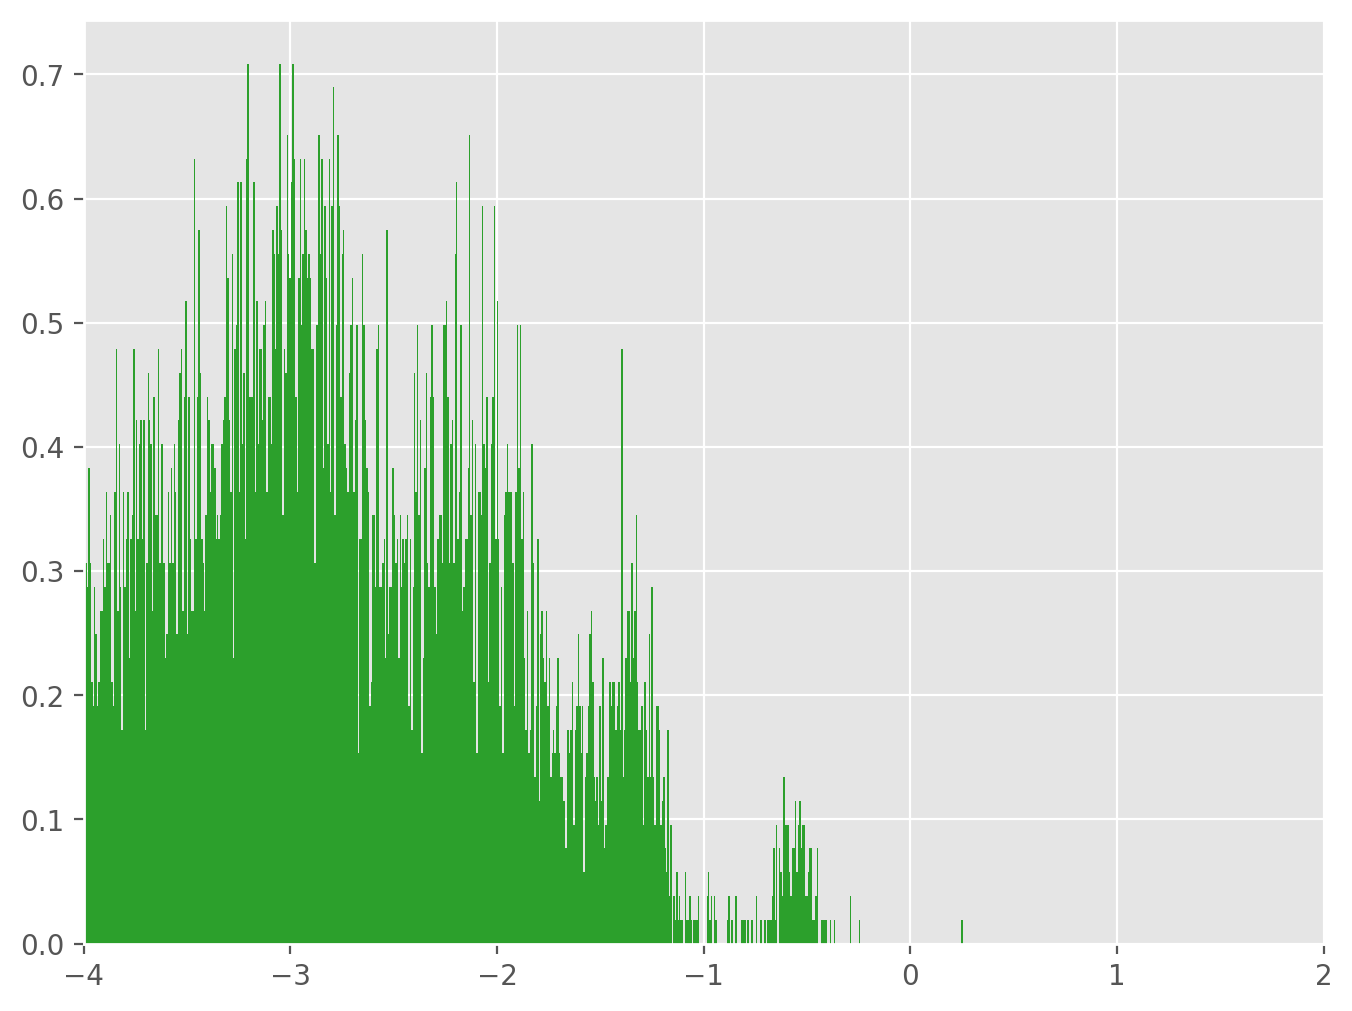

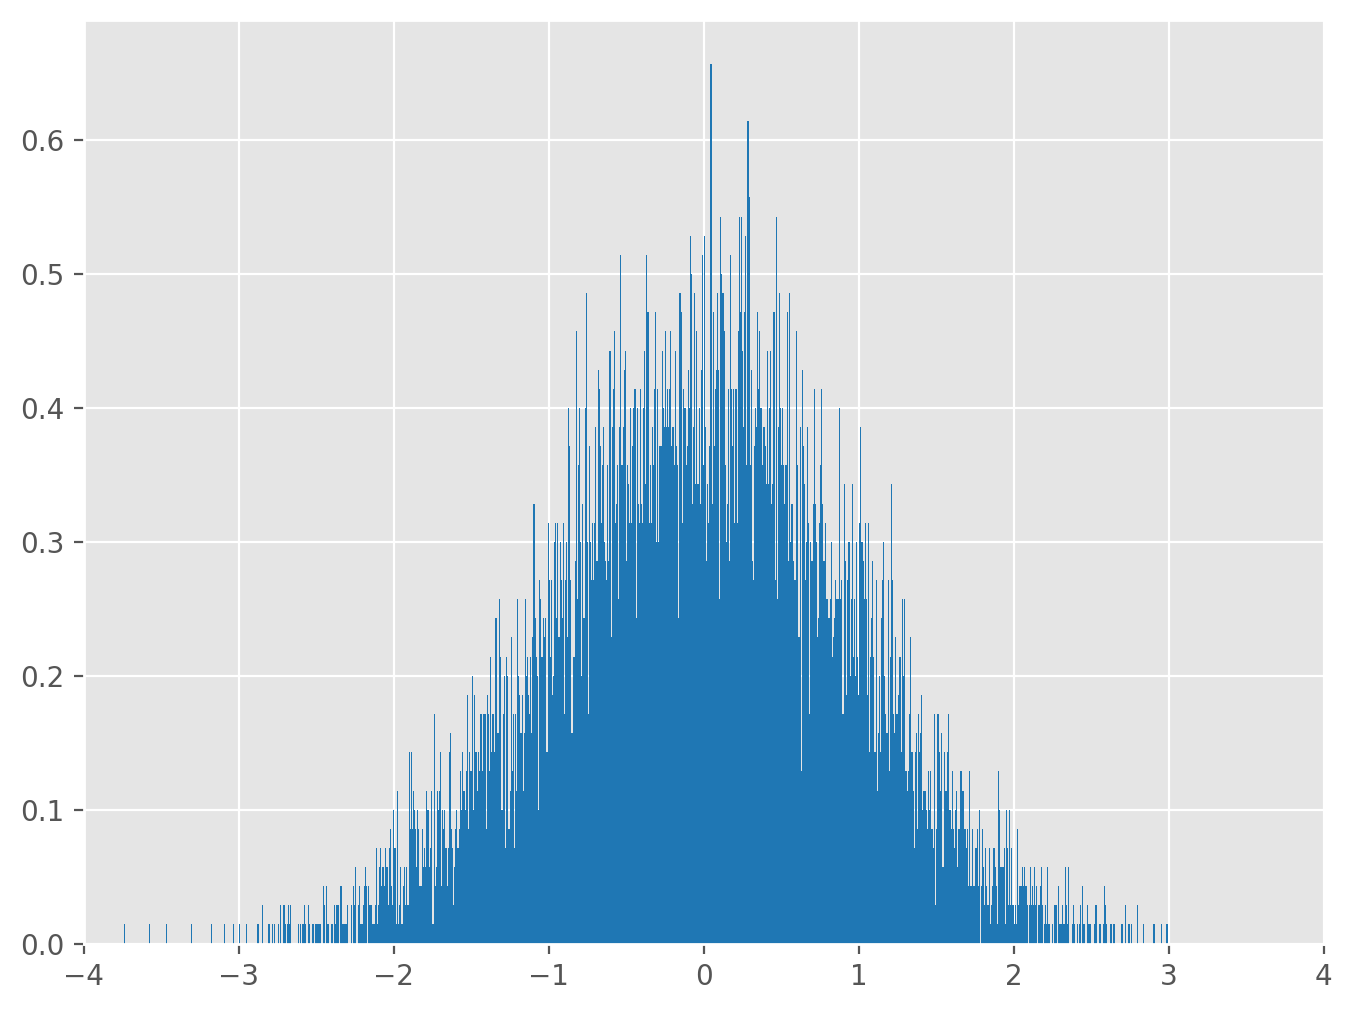

In [397]:
vals = list(df0.hc_greater) 
plt.hist(vals, bins = np.linspace(-4,3,1000), density=True, color='tab:green')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-4, 2])

plt.savefig(output_dir + f'Figs/hc_hist_T{T}.png')
plt.show()

vals = list(df0.log_rank_greater) 
plt.hist(vals, bins = np.linspace(-4,3,1000), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-4, 4])

plt.savefig(output_dir + 'Figs/lr_hist.png')
plt.show()

## Analyze Results

Use script in ``test_gene_expression.py`` to get the results

In [390]:
T = 200
stbl = True
res = pd.read_csv(f"results/SCANB_{stbl}_T{T}.csv")
#res = res[res.name.isin(gene_names)]

# T = 50
# stbl = False
# res = pd.read_csv(f"results/SCANB_{stbl}_T{T}.csv")

In [398]:
df0.agg([q95, q99])

,Unnamed: 0,log_rank_greater,log_rank_pval_greater,wilcoxon_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,name,x0,...,lam,log_rank_greater_rev,log_rank_pval_greater_rev,wilcoxon_greater_rev,hc_greater_rev,fisher_greater_rev,min_p_greater_rev,berk_jones_greater_rev,name_rev,itr
q95,0.0,1.535517,0.944006,1.399770,-1.396091,147.011448,2.831214,35.350506,NaN,1534.0,...,0.000643,1.589322,0.937672,1.613698,-1.395420,147.890614,2.836924,35.350506,NaN,9499.05
q99,0.0,2.167081,0.985816,1.835588,-0.612447,154.951175,4.121918,46.051702,NaN,1534.0,...,0.000647,2.192151,0.984886,2.108838,-0.619802,156.269845,4.125948,46.051702,NaN,9899.01


In [399]:
def find_pvalues_of_stats_results(df1, df0, stat_name):
    val0 =df0[stat_name]
    def stat0(x):
        return np.mean(val0 > x)

    return df1[stat_name].apply(stat0)

df0['log_rank_greater'] = np.random.randn(len(df0))
df0['log_rank_greater_rev'] = np.random.randn(len(df0))

sig_level = 0.01
for stat_name in ['hc_greater', 'log_rank_greater', 'hc_greater_rev', 'log_rank_greater_rev']:
    res.loc[:, stat_name + '_pvalue'] = find_pvalues_of_stats_results(res, df0, stat_name)
    
pvals = res.groupby('name')['hc_greater_pvalue'].mean()

pvals_sig = pvals[pvals < sig_level]
len(pvals_sig)

176

In [400]:
print("Total LR dicoveries: ", np.sum((res['log_rank_greater_pvalue'] <= sig_level) | (res['log_rank_greater_rev_pvalue'] <= sig_level)))
print("Total HC dicoveries: ",np.sum((res['hc_greater_pvalue'] <= sig_level) | (res['hc_greater_rev_pvalue'] <= sig_level)))

Total LR dicoveries:  2973
Total HC dicoveries:  252


In [401]:
log_rank_non = (res['log_rank_greater_pvalue'] > sig_level) & (res['log_rank_greater_rev_pvalue'] > sig_level)
log_rank_1side_strict = (res['log_rank_greater_pvalue'] <= sig_level) & (res['log_rank_greater_rev_pvalue'] > sig_level)
log_rank_1side_strict_rev = (res['log_rank_greater_pvalue'] > sig_level) & (res['log_rank_greater_rev_pvalue'] <= sig_level)
log_rank_2side = (res['log_rank_greater_pvalue'] <= sig_level) | (res['log_rank_greater_rev_pvalue'] <= sig_level)

log_rank_strict = log_rank_1side_strict | log_rank_1side_strict_rev

hc_non = (res['hc_greater_pvalue'] > sig_level) & (res['hc_greater_rev_pvalue'] > sig_level)
hc_1side_strict = (res['hc_greater_pvalue'] <= sig_level) & (res['hc_greater_rev_pvalue'] > sig_level)
hc_1side_strict_rev = (res['hc_greater_pvalue'] > sig_level) & (res['hc_greater_rev_pvalue'] <= sig_level)
hc_2side = (res['hc_greater_pvalue'] <= sig_level) | (res['hc_greater_rev_pvalue'] <= sig_level)

hc_strict = hc_1side_strict | hc_1side_strict_rev

print("Strictly one-sided effect:")
print("\tDiscoverable by HC: ", np.sum(hc_strict))
print("\tDiscoverable by LR: ", np.sum(log_rank_strict))

print("\tDiscoverable by HC and LR: ", np.sum(hc_strict & log_rank_strict))
print("\tDiscoverable by HC but not LR: ", np.sum(hc_strict & (1 - log_rank_strict) )   )
print("\tDiscoverable by LR but not HC: ", np.sum((1 - hc_strict) & ( log_rank_strict) )   )
print("\tDiscoverable by neigher HC nor LR: ", np.sum((1 - hc_strict) & (1 - log_rank_strict) )   )


print(" Either side effect:")

print("\tDiscoverable by HC: ", np.sum(hc_2side))
print("\tDiscoverable by LR: ", np.sum(log_rank_2side))


print("\tDiscoverable by HC and LR: ", np.sum(hc_2side & log_rank_2side))
print("\tDiscoverable by HC but not LR: ", np.sum(hc_2side & (1 - log_rank_2side) )   )
print("\tDiscoverable by LR but not HC: ", np.sum((1 - hc_2side) & ( log_rank_2side) )   )
print("\tDiscoverable by neigher HC nor LR: ", np.sum((1 - hc_2side) & (1 - log_rank_2side) )   )


Strictly one-sided effect:
	Discoverable by HC:  252
	Discoverable by LR:  2973
	Discoverable by HC and LR:  113
	Discoverable by HC but not LR:  139
	Discoverable by LR but not HC:  2860
	Discoverable by neigher HC nor LR:  5590
 Either side effect:
	Discoverable by HC:  252
	Discoverable by LR:  2973
	Discoverable by HC and LR:  113
	Discoverable by HC but not LR:  139
	Discoverable by LR but not HC:  2860
	Discoverable by neigher HC nor LR:  5590


### Arrange Results for presentation:

In [402]:
res['hc_pval'] = np.minimum(res['hc_greater_pvalue'], res['hc_greater_rev_pvalue'])
res['log_rank_pval'] = np.minimum(res['log_rank_greater_pvalue'], res['log_rank_greater_rev_pvalue'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

In [403]:
# take only those discovered by HC but not LR:
resi = res[hc_strict & (1 - log_rank_strict)].sort_values('l-ratio').filter(['name', 'hc_greater', 'hc_greater_rev',
                                            'log_rank_greater', 'log_rank_greater_rev',
                                            'hc_pval', 'log_rank_pval', 'l-ratio'
                                           ])
len(resi)
resi.head(20).name.values

array(['LRRC20', 'AVL9', 'PPCDC', 'PARP2', 'DNMT3A', 'COPS7B', 'FAM184A',
       'ID2', 'ERAL1', 'PRPS2', 'CASKIN2', 'VAMP5', 'CUEDC2', 'ATP6V0A1',
       'MYO7A', 'AZGP1', 'ERCC3', 'NDUFC1', 'MRPL46', 'CPVL'],
      dtype=object)

In [404]:
def prepare_for_display(resi_disp):
    flip_idc = resi_disp['hc_greater'] < resi_disp['hc_greater_rev']
    resi_disp['flip'] = '$>$ med'
    resi_disp.loc[flip_idc, 'flip'] = '$<$ med'
    resi_disp['hc'] = np.maximum(resi_disp['hc_greater'], resi_disp['hc_greater_rev'])
    resi_disp['log_rank'] = np.maximum(resi_disp['log_rank_greater'], resi_disp['log_rank_greater_rev'])
    rr = resi_disp.reset_index().filter(['name', 'hc', 'hc_pval', 'log_rank', 'log_rank_pval', 'flip'])
    return rr

prepare_for_display(resi)

,name,hc,hc_pval,log_rank,log_rank_pval,flip
0,LRRC20,-0.225556,0.0001,0.134702,0.4465,$>$ med
1,AVL9,-0.073736,0.0001,0.501558,0.3068,$>$ med
2,PPCDC,-0.332357,0.0004,0.037626,0.4852,$>$ med
3,PARP2,-0.367468,0.0004,0.147540,0.4347,$>$ med
4,DNMT3A,-0.290810,0.0003,0.598384,0.2676,$>$ med
...,...,...,...,...,...,...
134,GPR3,-0.593447,0.0082,2.165062,0.0157,$>$ med
135,DPEP3,-0.565760,0.0070,2.217902,0.0133,$>$ med
136,CXADR,-0.573128,0.0075,2.258181,0.0117,$>$ med
137,PRKX,-0.572565,0.0072,2.300642,0.0102,$<$ med


IndexError: index 0 is out of bounds for axis 0 with size 0

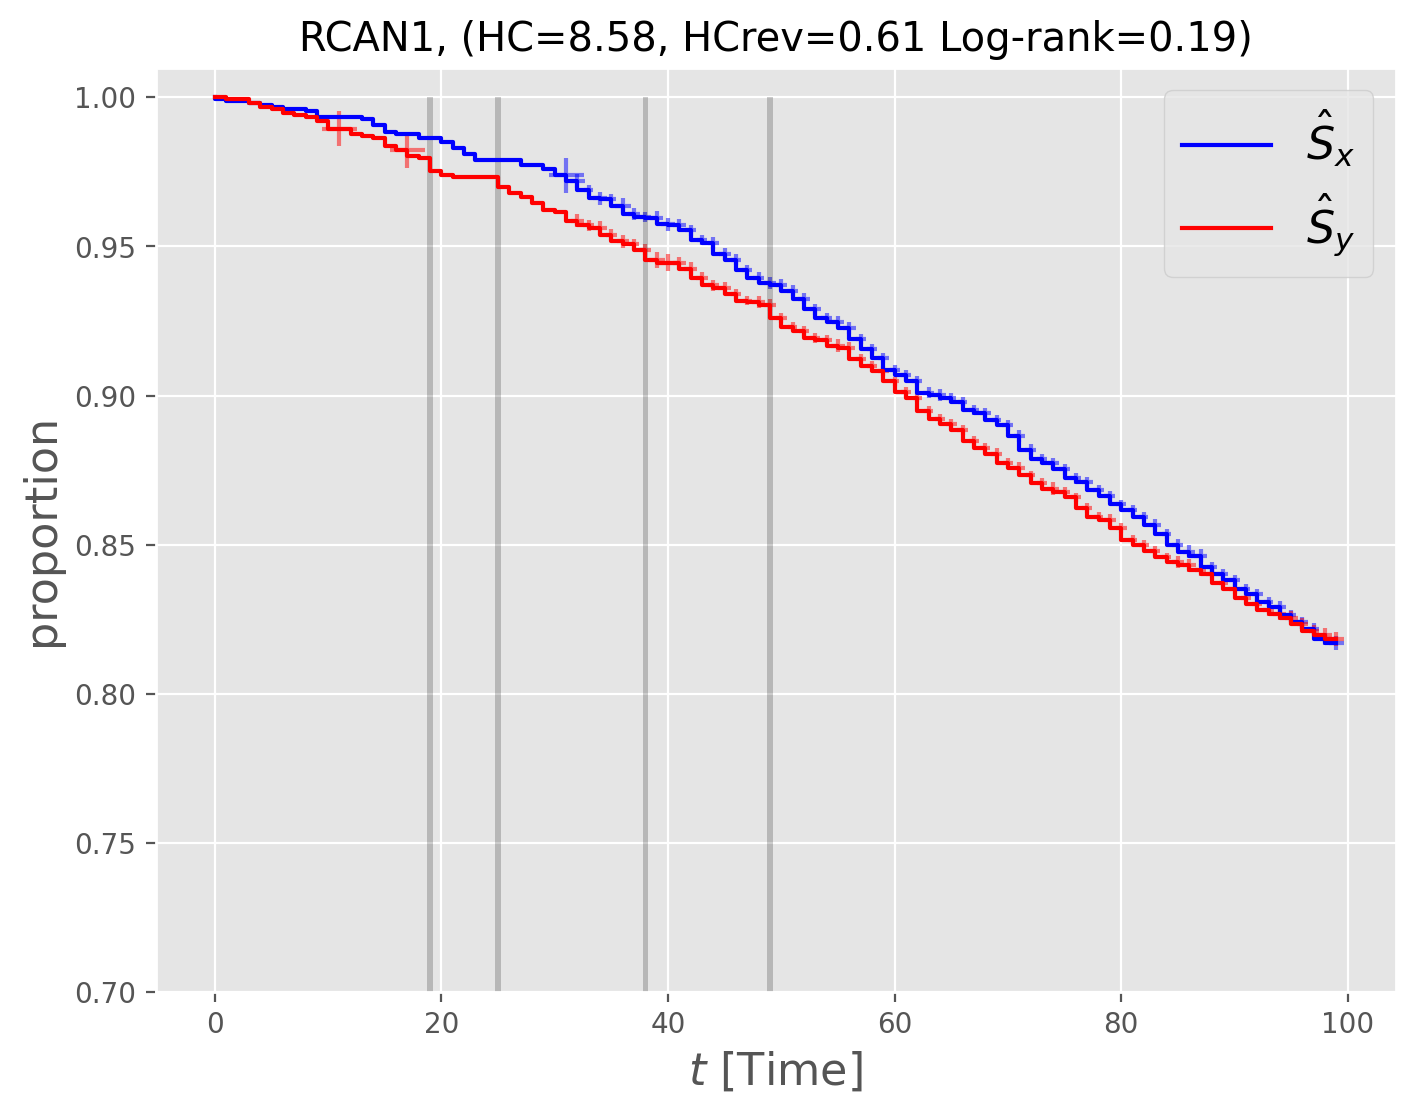

In [405]:
from illustrate_gene_expression_survival_curves import illustrate_survival_curve_gene

gene_name = 'RCAN1'
T = 100
dfp, dfg = illustrate_survival_curve_gene(df, gene_name, T, stbl=False,
                            show_HCT=True, randomize_HC=True,# show_HCrev=False
                            )
hc_pval =np.round(resi[resi.name == gene_name]['hc_pval'], 5).values[0]
log_rank_pval = np.round(resi[resi.name == gene_name]['log_rank_pval'], 4).values[0]
ax = plt.gca()
ax.set_title(fr"{gene_name}: $p(HC)$ = {hc_pval}, $p(LR)$={log_rank_pval}")
plt.savefig(f"{output_dir}Figs/{gene_name}.png")
dfp.index.name = 'time'
dfp.filter(['at-risk X', 'at-risk Y', 'events X', 'events Y', 'pvalue'])\
    .to_csv(output_dir + "csv/" + f'{gene_name}.csv')


,events X,events Y,censored1,censored2,at-risk X,at-risk Y,pvalue,pvalue_rev,Survival Proportion X,Survival Proportion Y
time,,,,,,,,,,
9,0.0,5.0,0.0,0.0,1524.0,1528.0,0.031353,1.0,0.993481,0.995440
38,0.0,5.0,14.0,12.0,1412.0,1404.0,0.030699,1.0,0.956224,0.946295
49,0.0,5.0,10.0,9.0,1281.0,1275.0,0.030764,1.0,0.935247,0.924088
50,0.0,5.0,11.0,12.0,1271.0,1261.0,0.030516,1.0,0.934718,0.919735
66,0.0,5.0,13.0,11.0,1069.0,1041.0,0.029089,1.0,0.898723,0.878840


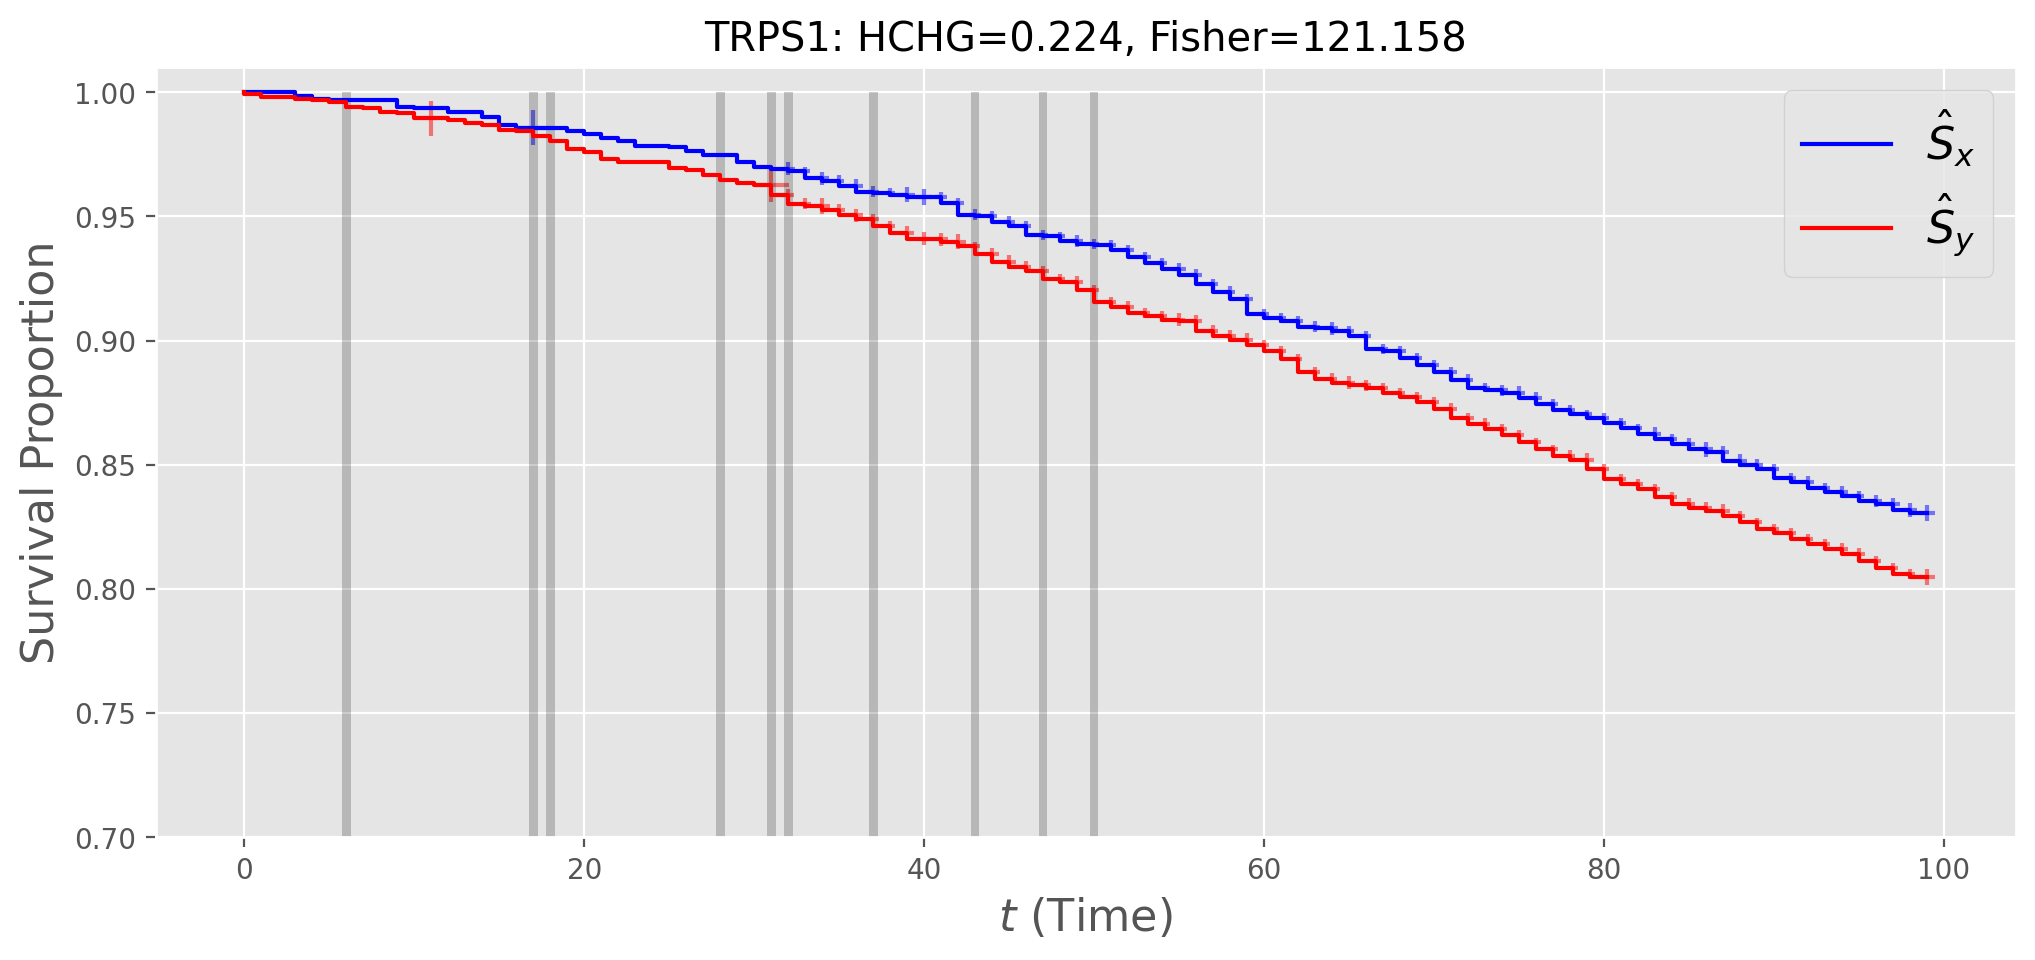

In [297]:
gene_name = 'TRPS1'
T = 100

from test_gene_expression import reduce_time_resolution, two_groups_gene
from survival import multi_pvals

dfg = reduce_time_resolution(two_groups_gene(df, gene_name), T)
Nt1, Nt2 = dfg['at-risk1'].values, dfg['at-risk2'].values
Ot1, Ot2 = dfg['dead1'].values, dfg['dead2'].values

def HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):

    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=randomize)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    fisher = mt.fisher()
        
    fpval = pvals <= hct
    
    dfg['pvalue'] = pvals
    dfg['t'] = np.arange(0,len(Ot1))

    cumc1 = dfg['censored1'].cumsum()
    cumc2 = dfg['censored2'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at-risk1'] - dfg['censored1']) / (dfg['at-risk1'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at-risk2'] - dfg['censored2']) / (dfg['at-risk2'].max() - cumc2)
        
    dfg['suspected'] = fpval
    return dfg.set_index('t'), hc, fisher[0]

def HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):
    
    dfg, hc, fisher = HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=randomize, stbl=stbl)
    
    fpval = dfg.suspected
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored1'] > 0
    ct2 = dfg['censored2'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored1'].max() / dfg.loc[ct1, 'censored1']).values
    s2 = 10 * (dfg.loc[ct2, 'censored2'].max() / dfg.loc[ct2, 'censored2']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1,'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2,'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)

    plt.title(rf"{gene_name}: HCHG={np.round(hc,3)}, Fisher={np.round(fisher,3)}")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    plt.ylim([0.7, 1.01])
    
    return dfg
    
dfg = HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2)
dfp

In [163]:
plt.rcParams['figure.figsize'] =  [12, 6]
plt.rcParams["figure.dpi"] = 200

list_to_plot = resi_disp.name.values
list_to_plot = ['TRPS1']

for gene_name in list_to_plot:
    df_disp, dfp = illustrate_survival_curve(df, df0, gene_name, T, stbl=True)
    plt.savefig(output_dir + "Figs/"  + gene_name + ".png")
    plt.show()

    dfd = df_disp.copy()
    dfd = dfd.iloc[:, :-2]

    for tag in ['pvalue', 'pvalue_rev']:
        dfd[tag] = np.round(dfd[tag],3)

    for tag in ['at-risk X', 'at-risk Y', 'events X', 'events Y']:
        dfd[tag] = dfd[tag].astype(int)

    dfd.index.name = 'time'
    dfd.filter(['at-risk X', 'at-risk Y', 'events X', 'events Y', 'pvalue', 'pvalue_rev'])\
        .to_csv(output_dir + "csv/" + f'{gene_name}.csv')


NameError: name 'resi_disp' is not defined

## Randomized P-values

In [375]:
resm = pd.read_csv("SCANB_True_T100_randomized_rep100.csv")

def rate_succ(xx):
    t = 1.41
    return np.mean(xx > t)

def pval_binom(x, n, p=sig_level):
    return np.binom.sf(x, n=100, p=p)

hc_sum = resm.groupby('name').hc_greater.agg(['mean', q95, rate_succ, 'count'])
hc_sum.sort_values('rate_succ', ascending=False).apply(pval_binom() )

,mean,q95,rate_succ,count
name,,,,
MTR,2.142463,2.672658,0.99,100
TRPS1,2.181579,2.805051,0.96,100
C11orf68,1.988362,2.613434,0.94,100
HIST1H4A,1.934908,2.484923,0.93,100
FBXL12,1.940221,2.612060,0.92,100
...,...,...,...,...
COX7C,0.379212,1.285728,0.00,100
DEDD,-0.035174,0.900712,0.00,100
LSS,0.096871,0.955187,0.00,100
